<a href="https://colab.research.google.com/github/jasonnho/flygaruda-sentiment-analysis/blob/main/notebook/flygaruda_regex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji

In [ ]:
#Import libraries

import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import emoji

In [ ]:
df = pd.read_csv('cleaned_garuda_reviews.csv')

In [ ]:
df.head()

,content,content_stemmed_no_common_2,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,harus belajar lagi bagaimana cara kau menghada...,"['ajar', 'kau', 'hadap', 'kritik', 'btw', 'mak...",4,0,6.16.0,2025-09-06 00:58:19,NaN,NaN
1,"maskapai maling, menipu customer dengan inform...","['maskapai', 'maling', 'tipu', 'customer', 'in...",1,1,NaN,2025-09-03 09:23:02,NaN,NaN
2,dulu dpt platinum bs 5-6 tahun g pernah turun....,"['platinum', '56', 'turun', 'bijak', 'megap2',...",2,2,6.17.0,2025-08-25 16:38:50,NaN,NaN
3,sy delay 20 jam dgn penerbangan conecting seha...,"['delay', '20', 'jam', 'terbang', 'conecting',...",1,0,6.17.0,2025-08-21 12:06:28,NaN,NaN
4,sedikit panik setelah check-in boarding tiket ...,"['panik', 'checkin', 'boarding', 'tiket', 'cum...",4,0,6.17.0,2025-08-18 05:44:32,NaN,NaN


In [ ]:
#Parse tokens dari file csv

import ast

col = "content_stemmed_no_common_2"

def parse_if_listlike(text):
    try:
        val = ast.literal_eval(text)
        if isinstance(val, list):
            return " ".join(val)      # jadi kalimat
    except Exception:
        pass
    return text

df[col] = df[col].astype(str).apply(parse_if_listlike)

In [ ]:
#Setup kolom
COL_IN = "content_stemmed_no_common_2"
COL_OUT = "content_regex"

df[COL_IN] = df[COL_IN]
df[COL_OUT] = df[COL_IN]

In [ ]:
#Hapus URL, email, mention, hashtag

df[COL_OUT] = (
    df[COL_OUT]
    .str.replace(r"https?://\S+|www\.\S+", " ", regex=True)
    .str.replace(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " ", regex=True)
    .str.replace(r"[@#]\w+", " ", regex=True)
)

In [ ]:
df[COL_OUT] = df[COL_OUT].apply(lambda x: emoji.replace_emoji(str(x), replace=" "))

In [ ]:
#Hapus pola yang tidak mau dianalisis di teks akhir

df[COL_OUT] = (
    df[COL_OUT]
    .str.replace(r"\b(?:rp|idr)\s?[\d\.]+(?:,\d{2})?\b", " ", regex=True)  # harga
    .str.replace(r"\bga\s?\d+\b", " ", regex=True)                        # flight number
)

In [ ]:
#Normalisasi huruf berulang: "baaguuuusss" -> "baagus"
df[COL_OUT] = df[COL_OUT].str.replace(r"(\w)\1{2,}", r"\1\1", regex=True)

# Menampilkan Least Word setelah melakukan Regex
Ada beberapa perbedaan jika dibandingkan dengan least word versi notebook preprocess sebelumnya, dimana ada beberapa kata dengan huruf yang berulang dan sudah hilang ketika melakukan regex. Namun, masih ada beberapa kata dengan huruf berulang dan harus ditangani. Selain itu juga terdapat angka yang bisa dihilangkan

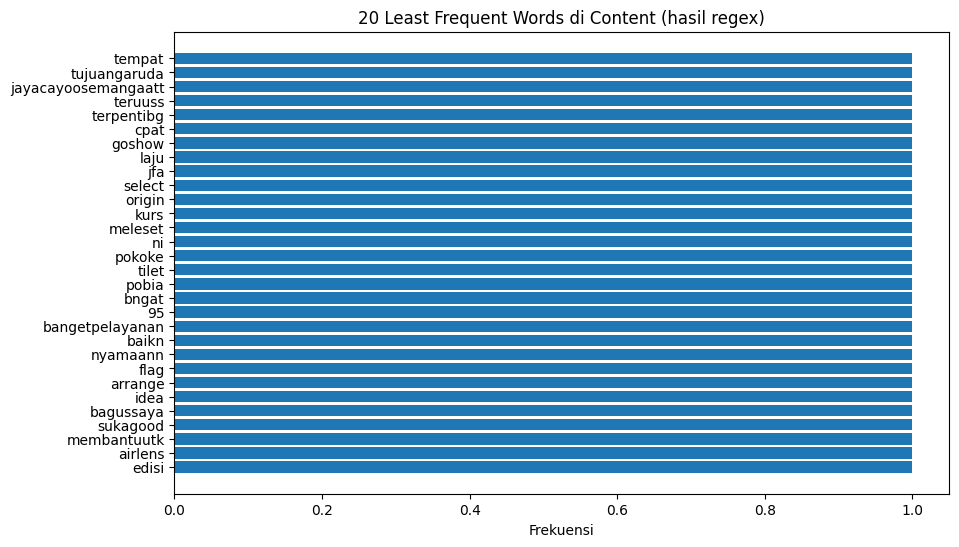

In [ ]:
# gabung semua teks jadi satu string besar
col = "content_regex"
all_words = " ".join(df[col]).split()

# hitung frekuensi
word_counts = Counter(all_words)

# ambil 20 kata dengan frekuensi paling kecil
least_common_20 = word_counts.most_common()[:-31:-1]  # ambil dari belakang

# pisahkan kata dan frekuensi
words, counts = zip(*least_common_20)

# visualisasi
plt.figure(figsize=(10,6))
plt.barh(words, counts)
plt.xlabel("Frekuensi")
plt.title("20 Least Frequent Words di Content (hasil regex)")
plt.show()

In [ ]:
#Menghilangkan angka
df[COL_OUT] = df[COL_OUT].str.replace(r"\d+", " ", regex=True)

In [ ]:
#Hilangkan spasi
df[COL_OUT] = df[COL_OUT].str.replace(r"\s+", " ", regex=True).str.strip()

In [ ]:
#Normalisasi kata yang masih mengandung huruf double
COL_BASE = "content_regex"
COL_NEW  = "content_regex_norm"

df[COL_NEW] = (
    df[COL_BASE].astype(str)
        .str.replace(r'(\w)\1{2,}', r'\1\1', regex=True)                     # ≥3 -> 2
        .str.replace(r'([bcdfghjklmnpqrstvwxyz])\1\b', r'\1', regex=True, case=False)  # akhir dobel konsonan -> 1
        .str.replace(r'(a)\1([bcdfghjklmnpqrstvwxyz])\b', r'\1\2', regex=True, case=False)  # HANYA 'aa' sebelum konsonan akhir
)



In [ ]:
#Tokenize lagi karena di parse sebelumnya

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# pilih kolom hasil regex terakhir
col_in = "content_regex_norm"
col_tok = "tokens_nltk"

# tokenisasi
df[col_tok] = df[col_in].astype(str).apply(word_tokenize)

# cek contoh
df[[col_in, col_tok]].head(10)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,content_regex_norm,tokens_nltk
0,ajar kau hadap kritik btw makannmu enak sorry ...,"[ajar, kau, hadap, kritik, btw, makannmu, enak..."
1,maskapai maling tipu customer informasi palsu ...,"[maskapai, maling, tipu, customer, informasi, ..."
2,platinum turun bijak megap tahan bronzesilver ...,"[platinum, turun, bijak, megap, tahan, bronzes..."
3,delay jam terbang conecting sore gatuda hai me...,"[delay, jam, terbang, conecting, sore, gatuda,..."
4,panik checkin boarding tiket cuman,"[panik, checkin, boarding, tiket, cuman]"
5,flygaruda tampil hasil telusur jadwal terbang ...,"[flygaruda, tampil, hasil, telusur, jadwal, te..."
6,buka akun loadingnya urung niat mending air as...,"[buka, akun, loadingnya, urung, niat, mending,..."
7,on scedule,"[on, scedule]"
8,gagal download boarding pas kadang lupa screen...,"[gagal, download, boarding, pas, kadang, lupa,..."
9,ok,[ok]


In [ ]:
print(df[[COL_IN, COL_BASE, COL_NEW]].head(10))

                         content_stemmed_no_common_2  \
0  ajar kau hadap kritik btw makannmu enak sorry ...   
1  maskapai maling tipu customer informasi palsu ...   
2  platinum 56 turun bijak megap2 tahan bronzesil...   
3  delay 20 jam terbang conecting sore gatuda hai...   
4                 panik checkin boarding tiket cuman   
5  flygaruda tampil hasil telusur jadwal terbang ...   
6  buka akun loadingnya urung niat mending air as...   
7                                         on scedule   
8  2025 gagal download boarding pass kadang lupa ...   
9                                                 ok   

                                       content_regex  \
0  ajar kau hadap kritik btw makannmu enak sorry ...   
1  maskapai maling tipu customer informasi palsu ...   
2  platinum turun bijak megap tahan bronzesilver ...   
3  delay jam terbang conecting sore gatuda hai me...   
4                 panik checkin boarding tiket cuman   
5  flygaruda tampil hasil telusur jadwal terban

#Hasil Akhir
Setelah preprocess dan melakukan regex, masih ada beberapa kata yang yang sulit untuk dinormalisasi atau dikoreksi pengejaannya. Karena tidak ada library atau tools untuk spelling correction atau sejenisnya dalam Bahasa Indonesia, kemungkinan kata kata ini akan dihilangkan bersamaan dengan least word removal nanti.

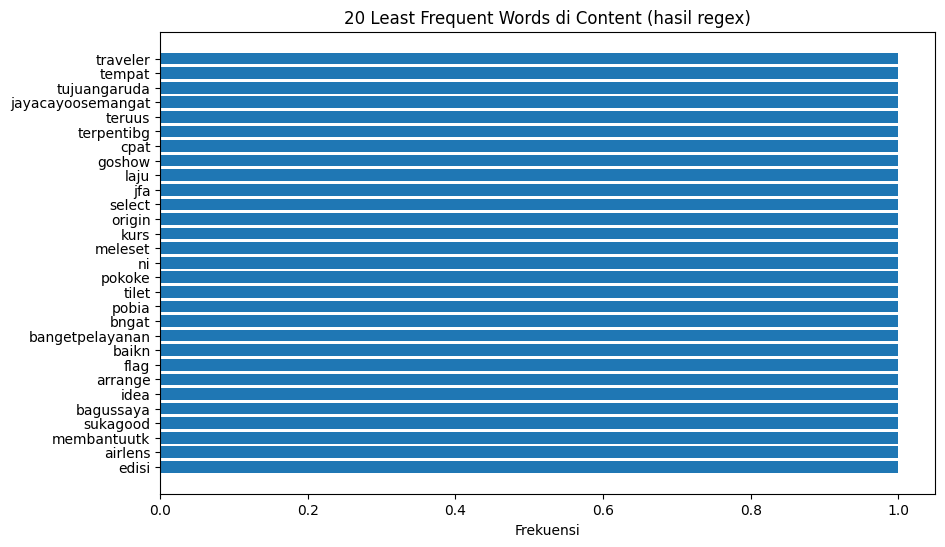

In [ ]:
# gabung semua teks jadi satu string besar
col = "content_regex_norm"
all_words = " ".join(df[col]).split()

# hitung frekuensi
word_counts = Counter(all_words)

# ambil 20 kata dengan frekuensi paling kecil
least_common_20 = word_counts.most_common()[:-30:-1]  # ambil dari belakang

# pisahkan kata dan frekuensi
words, counts = zip(*least_common_20)

# visualisasi
plt.figure(figsize=(10,6))
plt.barh(words, counts)
plt.xlabel("Frekuensi")
plt.title("20 Least Frequent Words di Content (hasil regex)")
plt.show()

In [ ]:
# Define the desired column order
desired_order = [
    'content',
    'content_stemmed_no_common_2',
    'content_regex',
    'content_regex_norm',
    'tokens_nltk',
    'score',
    'thumbsUpCount',
    'reviewCreatedVersion',
    'at',
    'replyContent',
    'repliedAt'
]

# Reindex the DataFrame with the desired order
df = df.reindex(columns=desired_order)

# Display the head of the modified DataFrame
df.head(5)

,content,content_stemmed_no_common_2,content_regex,content_regex_norm,tokens_nltk,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,harus belajar lagi bagaimana cara kau menghada...,ajar kau hadap kritik btw makannmu enak sorry ...,ajar kau hadap kritik btw makannmu enak sorry ...,ajar kau hadap kritik btw makannmu enak sorry ...,"[ajar, kau, hadap, kritik, btw, makannmu, enak...",4,0,6.16.0,2025-09-06 00:58:19,NaN,NaN
1,"maskapai maling, menipu customer dengan inform...",maskapai maling tipu customer informasi palsu ...,maskapai maling tipu customer informasi palsu ...,maskapai maling tipu customer informasi palsu ...,"[maskapai, maling, tipu, customer, informasi, ...",1,1,NaN,2025-09-03 09:23:02,NaN,NaN
2,dulu dpt platinum bs 5-6 tahun g pernah turun....,platinum 56 turun bijak megap2 tahan bronzesil...,platinum turun bijak megap tahan bronzesilver ...,platinum turun bijak megap tahan bronzesilver ...,"[platinum, turun, bijak, megap, tahan, bronzes...",2,2,6.17.0,2025-08-25 16:38:50,NaN,NaN
3,sy delay 20 jam dgn penerbangan conecting seha...,delay 20 jam terbang conecting sore gatuda hai...,delay jam terbang conecting sore gatuda hai me...,delay jam terbang conecting sore gatuda hai me...,"[delay, jam, terbang, conecting, sore, gatuda,...",1,0,6.17.0,2025-08-21 12:06:28,NaN,NaN
4,sedikit panik setelah check-in boarding tiket ...,panik checkin boarding tiket cuman,panik checkin boarding tiket cuman,panik checkin boarding tiket cuman,"[panik, checkin, boarding, tiket, cuman]",4,0,6.17.0,2025-08-18 05:44:32,NaN,NaN


In [ ]:
df.to_csv('regex_garuda_reviews.csv', index=False)
print("DataFrame exported to regex_garuda_reviews.csv")

DataFrame exported to regex_garuda_reviews.csv
